In [1]:
# Only run once!!
import os

os.chdir("../src/")

In [2]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler

import matplotlib as mpl
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, SGDRegressor, Ridge
import numpy as np
import cvxpy
from cvxpy import Variable, Minimize, Problem
from cvxpy import norm as cvxnorm

# from cvxpy import mul_elemwise, SCS
from cvxpy import vec as cvxvec

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme("notebook", "darkgrid")
palette = sns.color_palette("colorblind")
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["text.usetex"] = True

matplotlib.rcParams.update(
    {
        "axes.titlesize": 8,
        "figure.titlesize": 10,  # was 10
        "legend.fontsize": 10,  # was 10
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
    }
)
run_dir = "../models"

In [2]:
SPINE_COLOR = "gray"


def format_axes(ax):
    for spine in ["top", "right"]:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    for spine in ["left", "bottom"]:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction="out", color=SPINE_COLOR)
    return ax

In [3]:
task = "sign_vec_cs"
run_id = "final_model"  # Change according to the id of the model you train
dr_model, dr_conf = get_model_from_run(os.path.join(run_dir, task, run_id))
dr_model.to("cuda:0")

TransformerModel(
  (_read_in): Linear(in_features=20, out_features=256, bias=True)
  (_backbone): GPT2ModelWOPosEncodings(
    (wte): Embedding(50257, 256)
    (wpe): Embedding(202, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
        

In [4]:
batch_size = 1280  # 1280 #conf.training.batch_size
n_dims = 20
n_points = dr_conf.training.curriculum.points.end
data_sampler = get_data_sampler(dr_conf.training.data, n_dims)
task_sampler = get_task_sampler(
    dr_conf.training.task, n_dims, batch_size, **dr_conf.training.task_kwargs
)

In [5]:
seed = 42
torch.manual_seed(seed)
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=n_points)
ys = task.evaluate(xs)

In [6]:
with torch.no_grad():
    transformer_preds = dr_model(xs.to("cuda:0"), ys.to("cuda:0")).cpu()

In [7]:
metric = task.get_metric()
transformer_errors = metric(transformer_preds, ys).numpy().squeeze()

In [8]:
transformer_errors.mean(0)

array([2.0569822e+01, 1.9919622e+01, 1.8028030e+01, 1.5582985e+01,
       1.5564188e+01, 1.3203082e+01, 1.2920695e+01, 1.2352270e+01,
       1.1685841e+01, 8.8709431e+00, 6.0341864e+00, 4.2051935e+00,
       2.3442256e+00, 1.7058094e+00, 8.8033307e-01, 4.6238786e-01,
       2.3923668e-01, 1.5007965e-01, 9.1887131e-02, 7.9216138e-02,
       6.2065504e-02, 5.8131695e-02, 4.2671315e-02, 4.0061489e-02,
       3.2450631e-02, 3.0868605e-02, 2.8911242e-02, 2.3528751e-02,
       2.2488398e-02, 2.2915104e-02, 1.9956756e-02, 2.0291334e-02,
       1.8538464e-02, 1.7020460e-02, 1.7470172e-02, 1.5928958e-02,
       1.5667301e-02, 1.5348917e-02, 1.4321019e-02, 1.4748909e-02,
       1.5091513e-02], dtype=float32)

In [9]:
lsq_preds = [np.zeros(xs.shape[0])]
for i in tqdm(range(1, xs.shape[1])):
    preds = []
    for batch_id in range(xs.shape[0]):
        preds.append(
            LinearRegression(fit_intercept=False)
            .fit(xs[batch_id, :i], ys[batch_id, :i])
            .predict(xs[batch_id, i : i + 1])[0]
        )
    preds = np.array(preds).squeeze()
    lsq_preds.append(preds)
lsq_preds = np.array(lsq_preds)
lsq_preds = torch.tensor(lsq_preds.T).float()

  0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
lsq_errors = metric(lsq_preds, ys).numpy().squeeze()

In [ ]:
linf_norm_preds = []
w_stars = []
for b in tqdm(range(xs.shape[0])):
    preds = [0]
    for t in range(xs.shape[1] - 1):
        w_star = Variable([n_dims, 1])
        obj = Minimize(cvxnorm(w_star, "inf"))
        constraints = [
            ys[b, : t + 1].numpy()[:, np.newaxis] == (xs[b, : t + 1].numpy() @ w_star)
        ]
        prob = Problem(obj, constraints)
        result = prob.solve()
        try:
            pred = w_star.value[:, 0] @ xs[b, t + 1].numpy()
        except:
            pred = 0
        #         errors.append((pred - ys[b,t+1].numpy())**2)
        w_stars.append(w_star.value)
        preds.append(pred)
    linf_norm_preds.append(preds)
#     baseline_errors_batch.append(errors)
# np.mean(errors)
linf_norm_preds = torch.tensor(linf_norm_preds).float()

In [12]:
linf_norm_errors = metric(linf_norm_preds, ys).numpy().squeeze()
linf_norm_errors.shape

(1280, 41)

In [13]:
linf_norm_errors.mean(axis=0)

array([2.0593700e+01, 2.0545696e+01, 1.8637280e+01, 1.6905519e+01,
       1.7370770e+01, 1.4813227e+01, 1.4854256e+01, 1.4686655e+01,
       1.3172000e+01, 1.0167167e+01, 6.3961401e+00, 4.7136211e+00,
       1.9681752e+00, 1.0677903e+00, 5.9822446e-01, 1.5125912e-01,
       2.0956591e-02, 1.7947253e-03, 1.8605178e-12, 4.9572920e-12,
       1.9400812e-09, 1.2639915e+01, 1.7718447e+01, 2.0207279e+01,
       1.8954288e+01, 1.9724482e+01, 1.9619350e+01, 1.9619997e+01,
       2.0569828e+01, 2.0359951e+01, 2.0626301e+01, 1.9619171e+01,
       1.9771048e+01, 1.9140762e+01, 2.1040627e+01, 1.9656626e+01,
       2.0895746e+01, 1.8080690e+01, 2.0290384e+01, 1.9530802e+01,
       1.9563328e+01], dtype=float32)

In [14]:
def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax, seed):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        seed=seed,
        ci=90,
    )

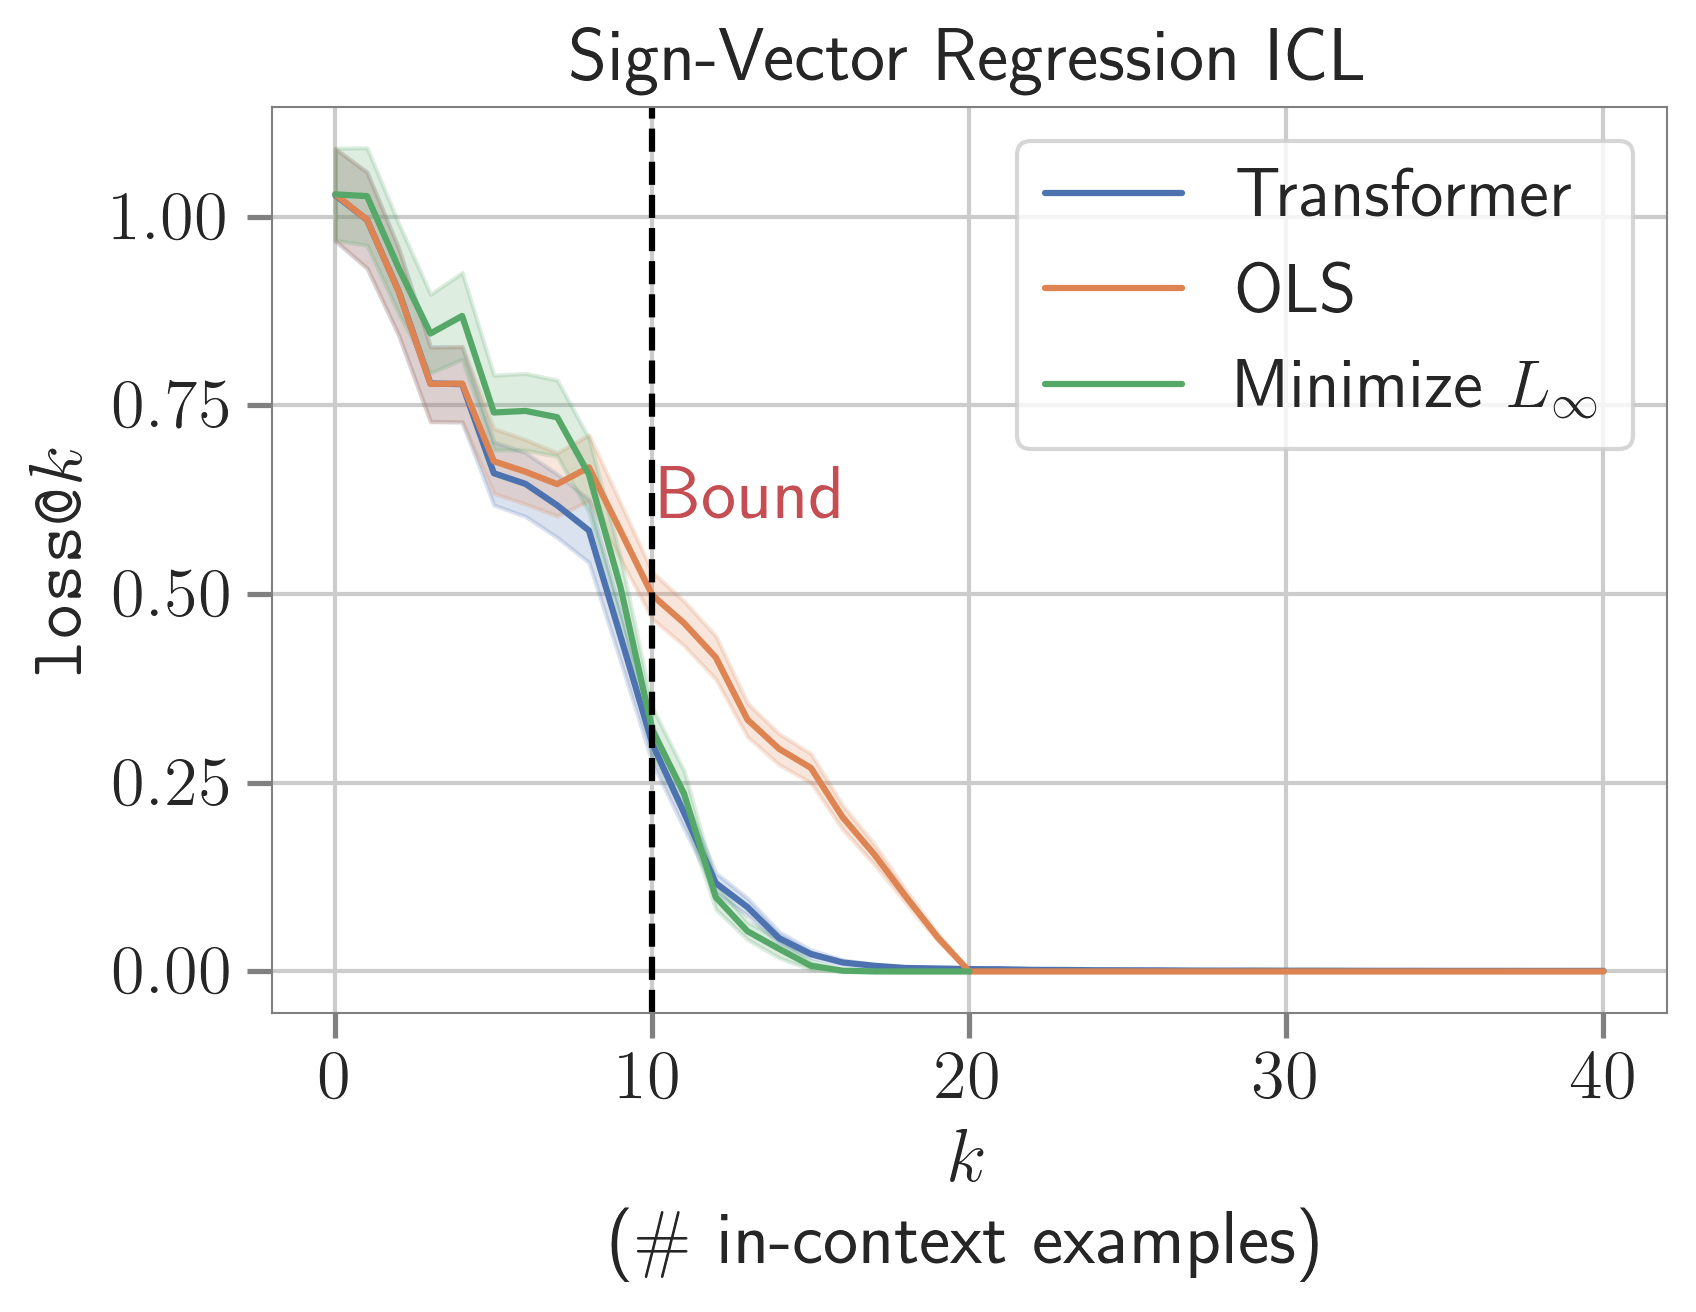

In [15]:
sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)
bound = n_dims / 2
fig, ax = plt.subplots()
# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    transformer_errors / n_dims,
    n_points,
    offset=0,
    label="Transformer",
    ax=ax,
    seed=seed,
)
lineplot_with_ci(lsq_errors / n_dims, n_points, offset=0, label="OLS", ax=ax, seed=seed)
lineplot_with_ci(
    (linf_norm_errors / n_dims)[:, : n_dims + 1],
    n_dims + 1,
    offset=0,
    label="Minimize $L_{\infty}$",
    ax=ax,
    seed=seed,
)
plt.axvline(bound, ls="--", color="black")
ax.annotate("Bound", xy=(bound + 0.25, 0.6), color="r", rotation=0)
# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax.set_xlabel("$k$\n(\# in-context examples)")
ax.set_ylabel("$\\texttt{loss@}k$")
ax.set_title("Sign-Vector Regression ICL")
format_axes(ax)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.legend()
plt.savefig("final_plots/svr_errors.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
def recover_weights_pv2(model, xs, ys, w_b, data_sampler):
    model.to("cuda:0")
    batch_size = xs.size(0)
    n_dims = w_b.size(1)

    x_probes = data_sampler.sample_xs(b_size=xs.shape[0], n_points=2 * xs.shape[-1] + 1)
    y_probes = []
    for i in range(2 * xs.shape[-1] + 1):
        x_prompt = torch.concat([xs, x_probes[:, i : i + 1, :]], axis=1)
        y_prompt = torch.concat([ys, torch.zeros(xs.shape[0], 1)], axis=1)
        with torch.no_grad():
            pred = model(x_prompt.to("cuda:0"), y_prompt.to("cuda:0")).cpu()
        y_probes.append(pred[:, -1:])

    y_probes = torch.cat(y_probes, axis=1)
    w_probed = []

    for batch in range(len(x_probes)):
        x, y = x_probes[batch], y_probes[batch]
        probe_model = LinearRegression(fit_intercept=False)
        probe_model.fit(x, y)
        w_probed.append(torch.tensor(probe_model.coef_[np.newaxis]).float())

    w_probed = torch.cat(w_probed, axis=0)
    error = ((w_probed - w_b[:, :, 0]) ** 2).mean(axis=1).mean()
    cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)(w_probed, w_b[:, :, 0]).mean()

    return w_b, w_probed, error, cos_sim

In [17]:
seed = 42
torch.manual_seed(seed)
batch_size = 1280
n_points = dr_conf.training.curriculum.points.end
data_sampler = get_data_sampler(dr_conf.training.data, n_dims)
task_sampler = get_task_sampler(
    dr_conf.training.task, n_dims, batch_size, **dr_conf.training.task_kwargs
)
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=n_points)
ys = task.evaluate(xs)

In [18]:
w_b, w_probed, error, cos_sim = recover_weights_pv2(
    dr_model, xs[:, :], ys[:, :], task.w_b, data_sampler
)

In [19]:
w_probed

tensor([[-0.9743,  1.0202, -1.0262,  ...,  1.0553,  1.0032, -0.9988],
        [ 0.9597, -1.0361,  1.0056,  ..., -0.9989, -0.9875, -1.0072],
        [-0.9655, -0.9761,  1.0317,  ..., -0.9618, -1.0270, -1.0219],
        ...,
        [-0.9897, -1.0214, -0.9740,  ..., -1.0207, -1.0406,  0.9695],
        [ 1.0117,  1.0251, -1.0308,  ...,  0.9744,  1.0034,  0.9813],
        [ 0.9908, -0.9977, -0.9751,  ...,  1.0429, -1.0325,  1.0105]])

In [20]:
cos_sim

tensor(0.9997)

In [21]:
w_probed_vecs = []
for n_points_i in tqdm(range(1, n_points)):
    _, w_probed, _, cos_sim = recover_weights_pv2(
        dr_model, xs[:, :n_points_i], ys[:, :n_points_i], task.w_b, data_sampler
    )
    w_probed_vecs.append(w_probed)

  0%|          | 0/40 [00:00<?, ?it/s]

In [22]:
# ridge_preds = [np.zeros(xs.shape[0])]
lsq_weights = []
for i in tqdm(range(1, xs.shape[1])):
    weights = []
    for batch_id in range(xs.shape[0]):
        lsq_model = LinearRegression(fit_intercept=False)
        lsq_model.fit(xs[batch_id, :i], ys[batch_id, :i])
        weights.append(lsq_model.coef_)
    lsq_weights.append(weights)
lsq_weights = np.array(lsq_weights)
# ridge_weights = torch.tensor(ridge_weights).transpose(0,1).float()

  0%|          | 0/40 [00:00<?, ?it/s]

In [23]:
lsq_weights = torch.tensor(lsq_weights).transpose(0, 1).float()

In [ ]:
linf_norm_weights = []
w_stars = []
for b in tqdm(range(xs.shape[0])):
    weights = []
    for t in range(xs.shape[1] - 1):
        w_star = Variable([n_dims, 1])
        obj = Minimize(cvxnorm(w_star, "inf"))
        constraints = [
            ys[b, : t + 1].numpy()[:, np.newaxis] == (xs[b, : t + 1].numpy() @ w_star)
        ]
        prob = Problem(obj, constraints)
        result = prob.solve()
        try:
            pred = w_star.value[:, 0] @ xs[b, t + 1].numpy()
        except:
            pred = 0
        #         errors.append((pred - ys[b,t+1].numpy())**2)
        weights.append(w_star.value)
    linf_norm_weights.append(weights)
#     baseline_errors_batch.append(errors)
# np.mean(errors)
linf_norm_weights = torch.tensor(linf_norm_weights).float()

In [25]:
linf_norm_weights = torch.tensor(
    [weights[:n_dims] for weights in linf_norm_weights]
).float()

/tmp/ipykernel_28567/3085265309.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  linf_norm_weights = torch.tensor([weights[:n_dims] for weights in linf_norm_weights]).float()


In [26]:
linf_norm_weights.shape

torch.Size([1280, 20, 20, 1])

In [27]:
# cos_sims_trans_lsq = []
# cos_sims_trans_linf = []
# cos_sims_trans_gold = []
# cos_sims_linf_gold = []
# gold_weights = task.w_b
# for n_points_i in tqdm(range(1, n_points)):

#     trans_weight_vect = w_probed_vecs[n_points_i - 1].squeeze()
#     lsq_weight_vect = lsq_weights[:, n_points_i - 1].squeeze()
#     linf_weight_vect = linf_norm_weights[:, min(n_points_i - 1, linf_norm_weights.shape[1] - 1)].squeeze()

#     cos_sims_trans_lsq.append(torch.nn.CosineSimilarity(dim = 1, eps = 1e-6)(trans_weight_vect, lsq_weight_vect))
#     cos_sims_trans_linf.append(torch.nn.CosineSimilarity(dim = 1, eps = 1e-6)(trans_weight_vect, linf_weight_vect))
#     cos_sims_trans_gold.append(torch.nn.CosineSimilarity(dim = 1, eps = 1e-6)(trans_weight_vect, gold_weights.squeeze()))
#     cos_sims_linf_gold.append(torch.nn.CosineSimilarity(dim = 1, eps = 1e-6)(linf_weight_vect, gold_weights.squeeze()))

In [28]:
# cos_sims_trans_lsq = torch.vstack(cos_sims_trans_lsq).transpose(0,1)
# cos_sims_trans_linf = torch.vstack(cos_sims_trans_linf).transpose(0,1)
# cos_sims_trans_gold = torch.vstack(cos_sims_trans_gold).transpose(0,1)
# cos_sims_linf_gold = torch.vstack(cos_sims_linf_gold).transpose(0,1)

In [29]:
# cos_sims_trans_gold

In [30]:
mse_trans_lsq = []
mse_trans_linf = []
mse_trans_gold = []
mse_linf_gold = []
gold_weights = task.w_b
for n_points_i in tqdm(range(1, n_points)):
    trans_weight_vect = w_probed_vecs[n_points_i - 1].squeeze()
    lsq_weight_vect = lsq_weights[:, n_points_i - 1].squeeze()
    linf_weight_vect = linf_norm_weights[
        :, min(n_points_i - 1, linf_norm_weights.shape[1] - 1)
    ].squeeze()

    mse_trans_lsq.append(((trans_weight_vect - lsq_weight_vect) ** 2).mean(axis=-1))
    mse_trans_linf.append(((trans_weight_vect - linf_weight_vect) ** 2).mean(axis=-1))
    mse_trans_gold.append(
        ((trans_weight_vect - gold_weights.squeeze()) ** 2).mean(axis=-1)
    )
    mse_linf_gold.append(
        ((linf_weight_vect - gold_weights.squeeze()) ** 2).mean(axis=-1)
    )

  0%|          | 0/40 [00:00<?, ?it/s]

In [31]:
mse_trans_lsq = torch.vstack(mse_trans_lsq).transpose(0, 1)
mse_trans_linf = torch.vstack(mse_trans_linf).transpose(0, 1)
mse_trans_gold = torch.vstack(mse_trans_gold).transpose(0, 1)
mse_lmse = torch.vstack(mse_linf_gold).transpose(0, 1)

In [32]:
# sns.set(style = "whitegrid", font_scale=1.5)
# # latexify(4, 3)

# fig, ax = plt.subplots()
# # ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# # ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
# lineplot_with_ci(cos_sims_trans_gold[:,:-1], n_points - 1, offset = 1, label="$(w^{\mathrm{probe}}, w)$", ax=ax, seed=seed)
# # lineplot_with_ci(lsq_errors, n_points, label="Least Squares", ax=ax, seed=seed)
# lineplot_with_ci(cos_sims_trans_lsq[:,:-1], n_points - 1,offset = 1, label="$(w^{\mathrm{probe}}, w^{\mathrm{OLS}})$", ax=ax, seed=seed)
# lineplot_with_ci(cos_sims_linf_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\mathrm{probe}}, w^{L_{\infty}})$", ax=ax, seed=seed)
# # lineplot_with_ci(cos_sims_linf_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\ell_{\infty}}, w)$", ax=ax, seed=seed)

# # lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
# ax.set_xlabel("$k$\n(\# in-context examples)")
# ax.set_ylabel("cosine similarity")
# ax.set_title("Sign-Vector Regression ICL")
# format_axes(ax)
# # plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
# plt.axvline(bound, ls="--", color="black")
# ax.annotate('Bound', xy=(bound + 0.25, 0.6), color='r', rotation=0)
# plt.legend()
# plt.savefig("final_plots/svr_probing.pdf", dpi = 300, bbox_inches = "tight")
# plt.show()

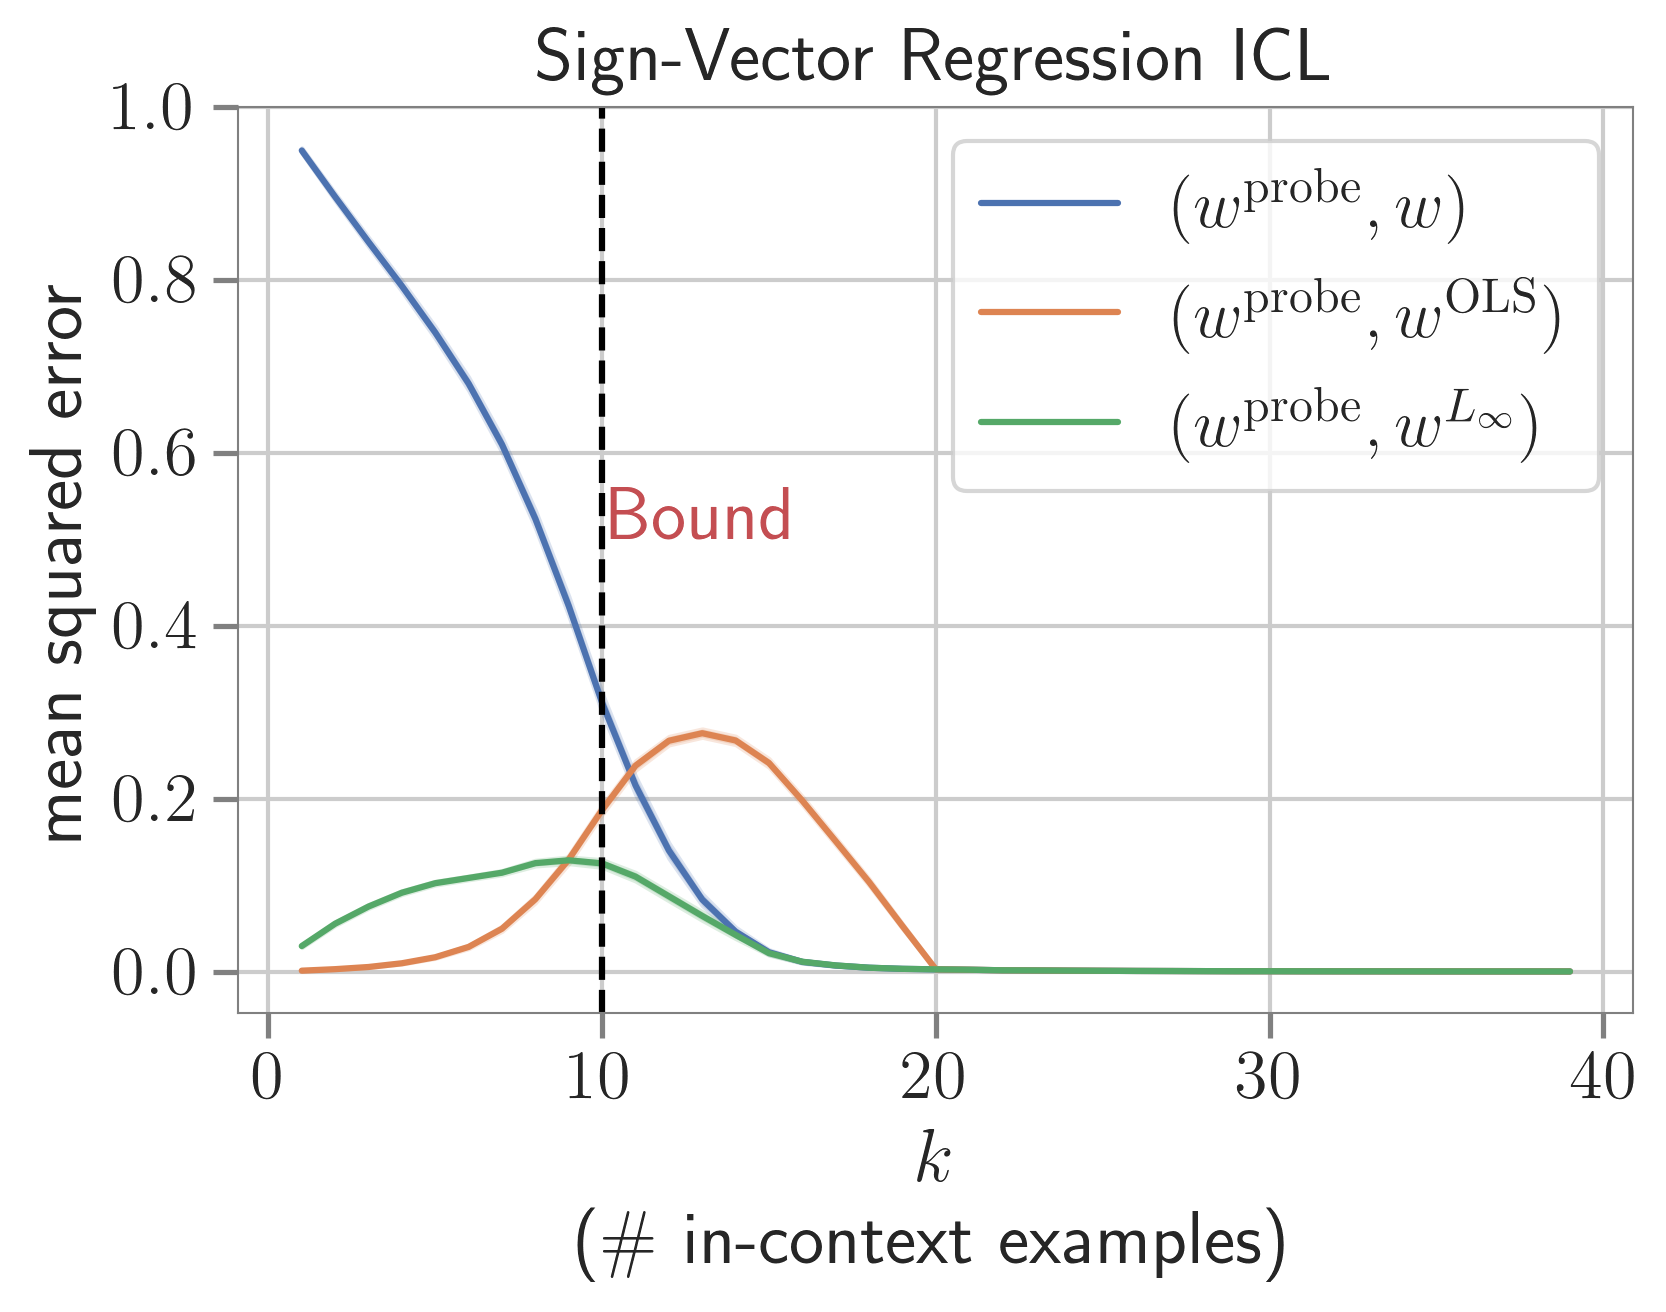

In [33]:
sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)

fig, ax = plt.subplots()
# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    mse_trans_gold[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w)$",
    ax=ax,
    seed=seed,
)
# lineplot_with_ci(lsq_errors, n_points, label="Least Squares", ax=ax, seed=seed)
lineplot_with_ci(
    mse_trans_lsq[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w^{\mathrm{OLS}})$",
    ax=ax,
    seed=seed,
)
lineplot_with_ci(
    mse_trans_linf[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{\mathrm{probe}}, w^{L_{\infty}})$",
    ax=ax,
    seed=seed,
)
# lineplot_with_ci(cos_sims_linf_gold[:,:-1], n_points - 1,offset = 1, label="$(w^{\ell_{\infty}}, w)$", ax=ax, seed=seed)

# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax.set_xlabel("$k$\n(\# in-context examples)")
ax.set_ylabel("mean squared error")
ax.set_title("Sign-Vector Regression ICL")
format_axes(ax)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.axvline(bound, ls="--", color="black")
ax.annotate("Bound", xy=(bound + 0.25, 0.5), color="r", rotation=0)
plt.legend()
plt.savefig("final_plots/svr_probing_mse.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [99]:
w_probed_vecs_t = torch.cat(
    [vec.unsqueeze(0) for vec in w_probed_vecs], axis=0
).transpose(0, 1)

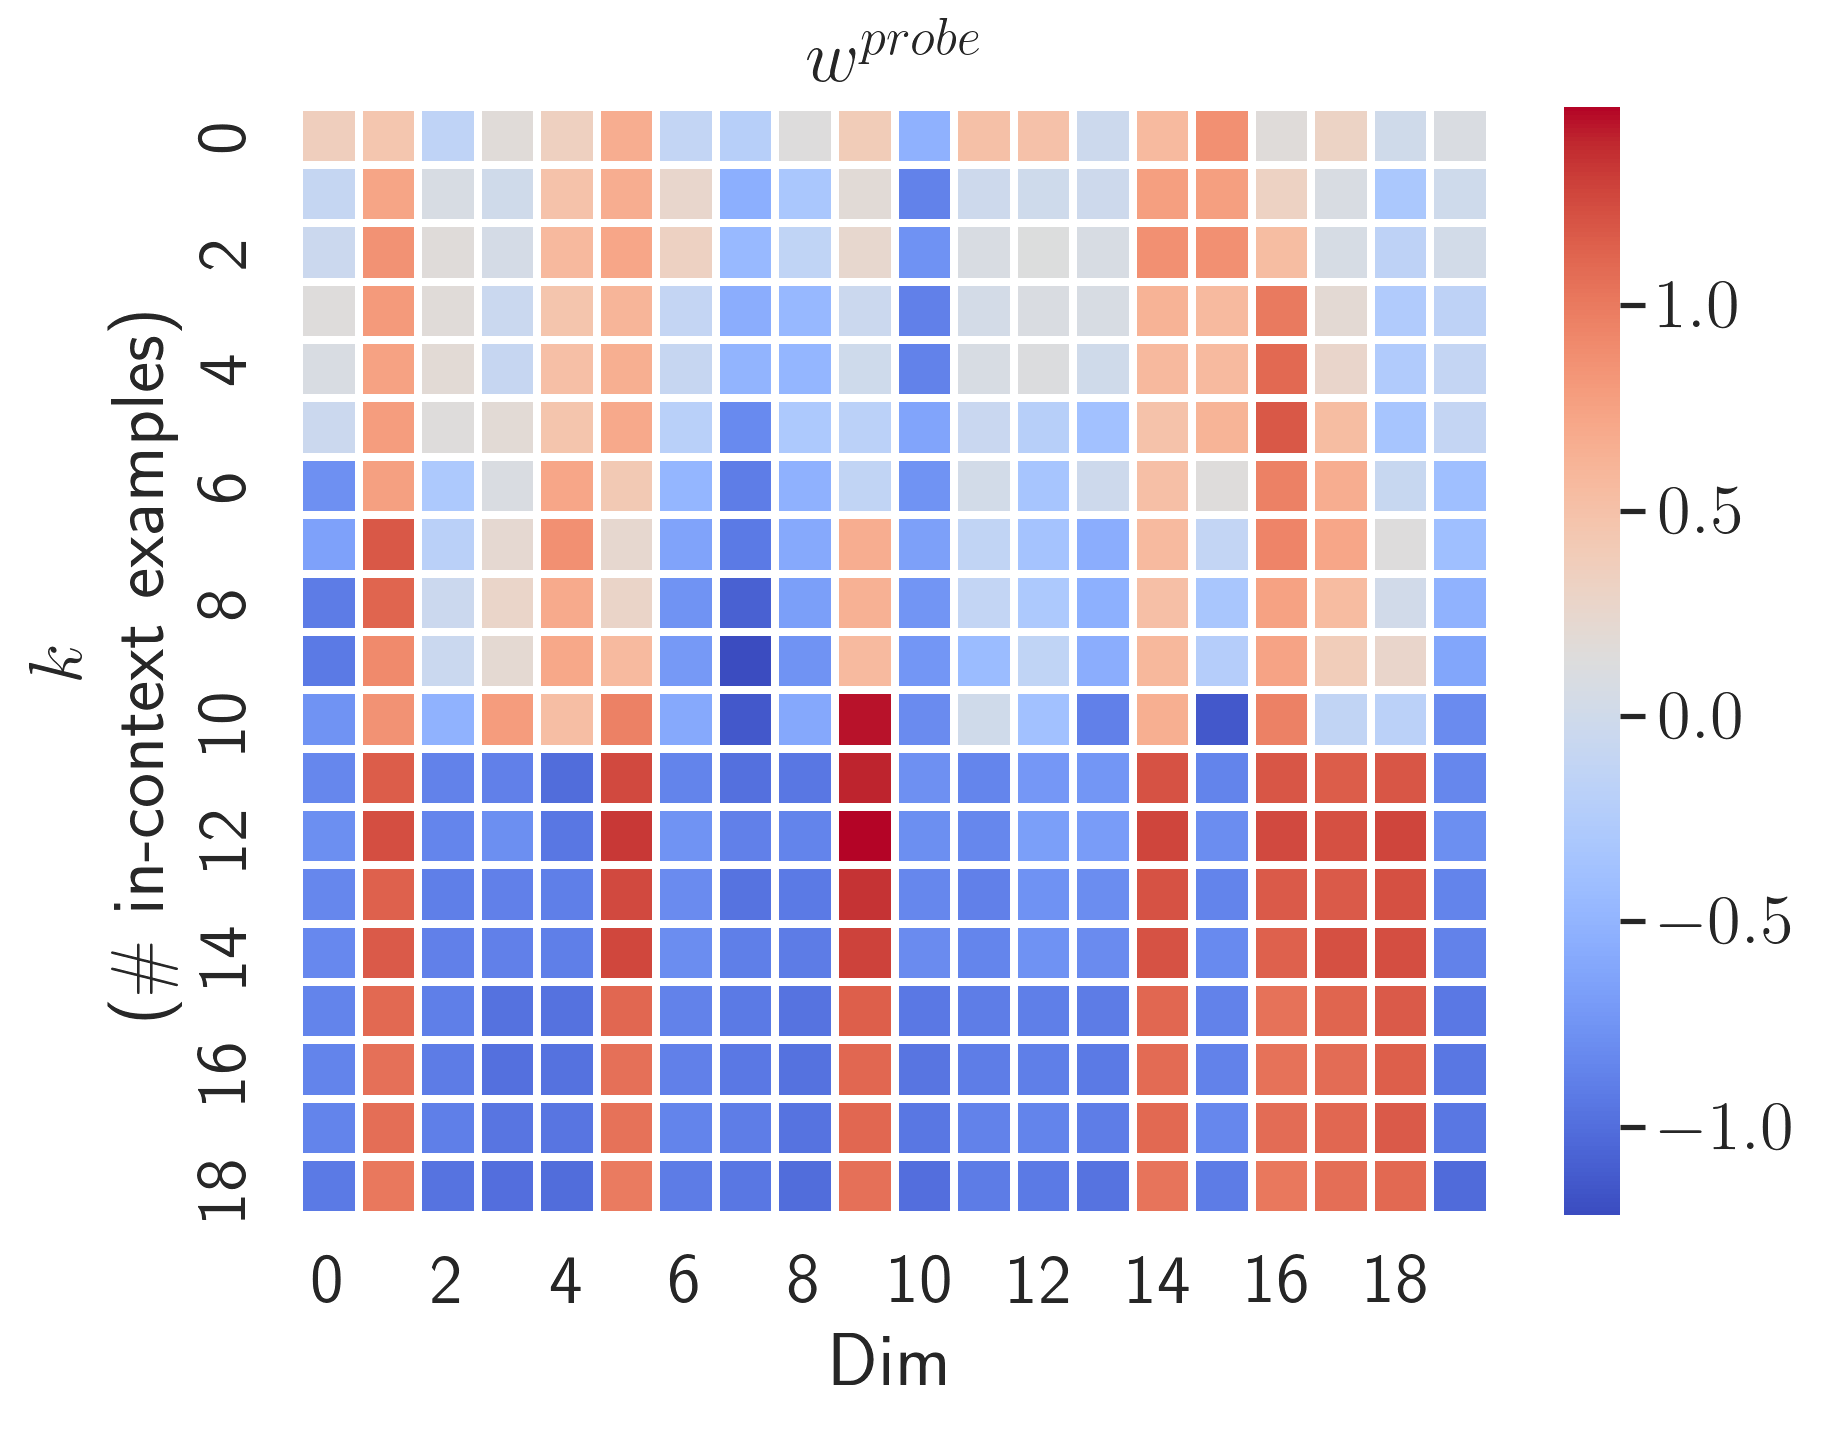

In [102]:
probe_weights_batch0 = w_probed_vecs_t[0][:20]

sns.heatmap(probe_weights_batch0, cmap="coolwarm", linewidth=1.5)
plt.title("$w^{probe}$")
plt.xlabel("Dim")
plt.ylabel("$k$\n(\# in-context examples)")
plt.savefig("final_plots/svr_w_probe.pdf", dpi=300, bbox_inches="tight")